In [53]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["TF_XLA_FLAGS"]="--tf_xla_cpu_global_jit"

import util_funcs
from importlib import reload
import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import constants
import ensembleReader as er
import clinical_text_analysis as cta
import tsfresh
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from os import path
import predictSeizureConvExp as psce
import keras_models.dataGen as dg
from addict import Dict
from pathlib import Path
reload(psce)
from keras.utils import multi_gpu_model
import keras.optimizers
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, log_loss

# load data with old way of data preprocessing

In [79]:
reload(dg)
import predictSeizureMultipleLabels as sml
reload(sml)
eds = sml.getDataSampleGenerator(pre_cooldown=0, post_cooldown=0, sample_time=1, num_seconds=2, n_process=4)
# EDS is returing a set of files with labels of seizure on granularity of num_seconds

Starting 4 processes
retrieving: 0
Starting 4 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [92]:
len(train_label_files_segs)

2531

In [80]:
eds = er.EdfDatasetSegments(pre_cooldown=0, post_cooldown=0, sample_time=0, num_seconds=1)
train_label_files_segs = eds.get_train_split()

Starting 20 processes
retrieving: 0
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000
starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [ ]:
train_label_files_segs[0][1].apply()

In [91]:
for i in range(0)
train_label_files_segs[0][1].loc[pd.Timedelta(seconds=0):pd.Timedelta(seconds=3)]

00:00:00    bckg
00:00:01    bckg
00:00:02    bckg
00:00:03    bckg
Freq: S, dtype: object

In [35]:
import mne
import pyprep
from pyprep import PrepPipeline
data = mne.io.read_raw_edf(train_label_files_segs[0][0], preload=True)
data = data.pick_channels(util_funcs.get_common_channel_names())
data = data.reorder_channels(util_funcs.get_common_channel_names())
data.rename_channels(constants.MNE_CHANNEL_EDF_MAPPING)
data.set_montage("standard_1020")
montage_kind = "standard_1020"
maxTime = train_label_files_segs[0][1].index.max()/pd.Timedelta(seconds=1)
montage = mne.channels.make_standard_montage(montage_kind)


Extracting EDF parameters from /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1304999  =      0.000 ...  1304.999 secs...
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}


In [41]:
np.arange(60, data.info["sfreq"]/2, 60)

array([ 60., 120., 180., 240., 300., 360., 420., 480.])

In [60]:
train_label_files_segs[0][0]

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf'

In [61]:
train_label_files_segs[0][0][:-4]+".tse"

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.tse'

'/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001.txt'

In [71]:
%%bash
ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/

00013182_s001.txt
00013182_s001_t000.edf
00013182_s001_t000.lbl
00013182_s001_t000.lbl_bi
00013182_s001_t000.tse
00013182_s001_t000.tse_bi


In [52]:
ref, patient, session, token = read.parse_edf_token_path_structure(train_label_files_segs[0][0])

In [77]:
# for i in range(int(maxTime/2)):
basePath = f"/n/scratch2/ms994/prep/train/{patient}/{session}/{token}/"
Path(basePath).mkdir( parents=True, exist_ok=True)
import shutil
shutil.copyfile(train_label_files_segs[0][0][:-4]+".tse", f"{basePath}label.tse")
shutil.copyfile(train_label_files_segs[0][0][:-4]+".lbl", f"{basePath}montage.lbl")
shutil.copyfile(train_label_files_segs[0][0][:-9]+".txt", f"{basePath}notes.txt")

for i in range(10):
    croppedData = data.copy().crop(i*2, i*2 + 4)
    croppedData.resample(512) #upsample to highest frequency, as per best practice
    prep_params = {'ref_chs': data.ch_names,
                   'reref_chs': data.ch_names,
                   'line_freqs': np.arange(60, croppedData.info["sfreq"]/2, 60)}
    prep = pyprep.PrepPipeline(croppedData, prep_params, montage, ransac=True)
    try:
        prep.fit()
        prep.raw.resample(constants.COMMON_FREQ) #downsample to common freq
        prep.raw.save(basePath+f"start_{i*2}_end_{i*2+4}.raw.fif", overwrite=True)
    except:
        print("failed to run prep, data segment was too noisy")
   

DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Settin

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) me

/home/ms994/pyprep/pyprep/reference.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Overwriting existing file.
Writing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_2_end_6.raw.fif
Closing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_2_end_6.raw.fif [done]
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain 

/home/ms994/pyprep/pyprep/reference.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Overwriting existing file.
Writing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_4_end_8.raw.fif
Closing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_4_end_8.raw.fif [done]
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain 

/home/ms994/pyprep/pyprep/reference.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Overwriting existing file.
Writing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_6_end_10.raw.fif
Closing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_6_end_10.raw.fif [done]
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domai

/home/ms994/pyprep/pyprep/reference.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Overwriting existing file.
Writing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_8_end_12.raw.fif
Closing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_8_end_12.raw.fif [done]
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domai

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)

Found 1 uniquely bad channels.

0 by n/a: []

0 by flat: []

1 by deviation: ['Fp2']

0 by hf noise: []

0 by correl: []

0 by SNR []

0 by dropout: []

0 by ransac: []
Computing interpolation matrix from 20 sensor positions
Interpolating 1 sensors
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causa

/home/ms994/pyprep/pyprep/reference.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Overwriting existing file.
Writing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_14_end_18.raw.fif
Closing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_14_end_18.raw.fif [done]
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-dom

/home/ms994/pyprep/pyprep/reference.py:90: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  self.raw.interpolate_bads()


Overwriting existing file.
Writing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_16_end_20.raw.fif
Closing /n/scratch2/ms994/prep/train/00013182/s001_2015_10_07/00013182_s001_t000.edf/start_16_end_20.raw.fif [done]
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'FT10', 'PO10', 'AF5', 'TP10', 'PO5', 'FC3', 'POz', 'O9', 'C5', 'PO9', 'AF4', 'FC4', 'AF10', 'M1', 'P1', 'CP4', 'C6', 'CP1', 'AF8', 'CP3', 'PO7', 'T10', 'FT7', 'F2', 'P10', 'P8', 'F5', 'FC6', 'AF3', 'PO6', 'AF9', 'TP7', 'PO8', 'O10', 'TP9', 'Fpz', 'M2', 'CP2', 'C1', 'TP8', 'CP5', 'P5', 'PO3', 'P2', 'PO4', 'AF7', 'AF6', 'PO2', 'FC1', 'F6', 'T7', 'FC5', 'FT8', 'Iz', 'F1', 'CPz', 'AF1', 'Oz', 'FC2', 'PO1', 'T9', 'FCz', 'AFz', 'C2', 'AF2', 'CP6', 'F9', 'T8', 'P7', 'FT9', 'F10', 'P9', 'P6'}
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-dom

In [78]:
train_label_files_segs[0][1]

00:00:00    bckg
00:00:01    bckg
00:00:02    bckg
00:00:03    bckg
00:00:04    bckg
00:00:05    bckg
00:00:06    bckg
00:00:07    bckg
00:00:08    bckg
00:00:09    bckg
00:00:10    bckg
00:00:11    bckg
00:00:12    bckg
00:00:13    bckg
00:00:14    bckg
00:00:15    bckg
00:00:16    bckg
00:00:17    bckg
00:00:18    bckg
00:00:19    bckg
00:00:20    bckg
00:00:21    bckg
00:00:22    bckg
00:00:23    bckg
00:00:24    bckg
00:00:25    bckg
00:00:26    bckg
00:00:27    bckg
00:00:28    bckg
00:00:29    bckg
            ... 
00:21:14    bckg
00:21:15    bckg
00:21:16    bckg
00:21:17    bckg
00:21:18    bckg
00:21:19    bckg
00:21:20    bckg
00:21:21    bckg
00:21:22    bckg
00:21:23    bckg
00:21:24    bckg
00:21:25    bckg
00:21:26    bckg
00:21:27    bckg
00:21:28    bckg
00:21:29    bckg
00:21:30    bckg
00:21:31    bckg
00:21:32    bckg
00:21:33    bckg
00:21:34    bckg
00:21:35    bckg
00:21:36    bckg
00:21:37    bckg
00:21:38    bckg
00:21:39    bckg
00:21:40    bckg
00:21:41    bc

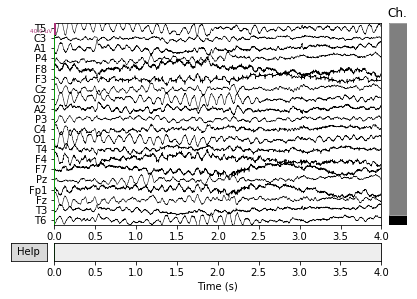

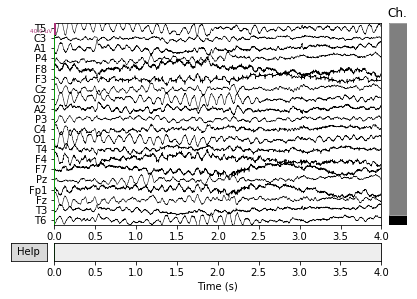

In [44]:
prep.raw.get_data()

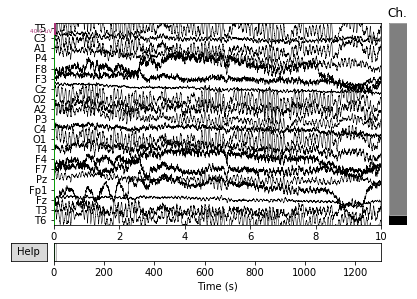

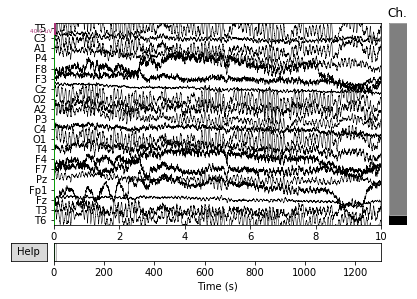

In [27]:
croppedData = data.copy().crop(10,20)
data.plot()

In [ ]:
for i in range(400):
    data = mne.io.read_raw_edf(edf_files[580], preload=True)
    data = data.pick_channels(util_funcs.get_common_channel_names())
    data.rename_channels(constants.MNE_CHANNEL_EDF_MAPPING)
    data.set_montage("standard_1020")
    montage_kind = "standard_1020"
    prep_params = {'ref_chs': data.ch_names,
                   'reref_chs': data.ch_names,
                   'line_freqs': np.arange(60, data.info["sfreq"]/2, 60)}
    montage = mne.channels.make_standard_montage(montage_kind)
    dataSubset = data.copy().crop(i*10,i*10+30)
    prep = pyprep.PrepPipeline(dataSubset, prep_params, montage)
    try:
        prep.fit()
        success+=1
    except Exception:
        print("failure")
        fails += 1

In [5]:
seizure_label = train_label_files_segs[0][1]

In [ ]:
train_la

In [6]:
train_label_files_segs = eds.get_train_split()
train_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=train_label_files_segs, num_samples=4, max_bckg_samps_per_file=4, n_process=8, gap=4*pd.Timedelta(seconds=1))
train_tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]
train_patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] for tkn_file_path in train_tkn_file_paths]
valid_label_files_segs = eds.get_v
edg = dg.RULDataGenMultipleLabels(train_edss, num_labels=2, labels=[seizureLabels, patientInd], xy_tuple_form=True, n_classes=(2, len(allPatients)), use_background_process=False, precache=True, batch_size=32)
valid_edg = dg.RULDataGenMultipleLabels(valid_edss, num_labels=2, labels=[validSeizureLabels, validPatientInd], xy_tuple_form=True, n_classes=(2, len(allPatients)), shuffle=False, use_background_process=False, precache=True, batch_size=64)

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


NameError: name 'er' is not defined

# Compare with MNE data tooling

In [20]:
import mne
import mne.io
import pyprep
import os
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

In [12]:
data = mne.io.read_raw_edf(train_label_files_segs[0][0], preload=True)
data = data.pick_channels(util_funcs.get_common_channel_names())
data.rename_channels(constants.MNE_CHANNEL_EDF_MAPPING)
data.set_montage("standard_1020")
montage_kind = "standard_1020"
prep_params = {'ref_chs': data.ch_names,
               'reref_chs': data.ch_names,
               'line_freqs': np.arange(60, data.info["sfreq"]/2, 60)}
montage = mne.channels.make_standard_montage(montage_kind)

Extracting EDF parameters from /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013145/s007_2015_09_04/00013145_s007_t008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
DigMontage is a superset of info. 73 in DigMontage will be ignored. The ignored channels are: {'T7', 'Iz', 'AF2', 'CPz', 'P10', 'F1', 'F2', 'C1', 'AF9', 'P6', 'TP10', 'AFz', 'C5', 'FCz', 'PO4', 'M2', 'FC6', 'CP5', 'AF6', 'FC2', 'CP3', 'AF8', 'TP9', 'T10', 'P8', 'PO6', 'FT7', 'P5', 'FT9', 'PO5', 'C2', 'CP1', 'FC5', 'F5', 'POz', 'PO2', 'O10', 'FC4', 'AF1', 'T8', 'TP7', 'CP2', 'PO1', 'PO10', 'Fpz', 'P7', 'FT10', 'O9', 'F10', 'FC3', 'P1', 'PO8', 'CP4', 'PO3', 'AF4', 'AF5', 'FC1', 'M1', 'AF3', 'TP8', 'AF7', 'C6', 'FT8', 'PO9', 'AF10', 'T9', 'PO7', 'F9', 'CP6', 'Oz', 'P2', 'P9', 'F6'}


In [16]:
filter_data = data.filter(l_freq=1., h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



In [21]:
ica = ICA(n_components=15, random_state=97)
ica.fit(filter_data)

Fitting ICA to data using 21 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 15 components
Fitting ICA took 1.0s.


<ICA  |  raw data decomposition, fit (fastica): 153856 samples, 15 components, channels used: "eeg">

In [35]:
read.read_tse_file(train_label_files_segs[0][0][:-4]+".tse")

,start,end,label,p,duration
0,0,601,bckg,1,601


In [39]:
epochs = mne.Epochs(data, events=[])

IndexError: too many indices for array

In [49]:
from joblib import Parallel, delayed

In [41]:
import time

In [57]:
sqrt = np.sqrt
start = time.time()
res = Parallel(4)(delayed(sqrt)(i) for i in range(100000))
end = time.time()

In [58]:
end - start

3.6995697021484375

In [59]:
from multiprocessing import Pool

In [60]:
p = Pool(10)
p.r